<a href="https://colab.research.google.com/github/stahelin/puc_dl2cv/blob/main/simvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 - Instalando todas as dependencias do OpenSTL (Mesmo que redundantes, por garantia) e montando o Drive
*Reinicie o ambiente de execução antes de prosseguir para utilizar as versões mais recentes instaladas


In [5]:
!git clone https://github.com/chengtan9907/OpenSTL

Cloning into 'OpenSTL'...
remote: Enumerating objects: 2259, done.
remote: Counting objects: 100% (763/763), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 2259 (delta 657), reused 592 (delta 574), pack-reused 1496
Receiving objects: 100% (2259/2259), 2.13 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (1650/1650), done.


In [6]:
import os
!pip install fvcore
!pip install -e OpenSTL
os.chdir('/content/OpenSTL')

Obtaining file:///content/OpenSTL/OpenSTL
  Preparing metadata (setup.py) ... done
  Attempting uninstall: OpenSTL
    Found existing installation: OpenSTL 0.3.0
    Uninstalling OpenSTL-0.3.0:
      Successfully uninstalled OpenSTL-0.3.0
  Running setup.py develop for OpenSTL


In [7]:
!pip install argparse
!pip install dask
!pip install decord
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install hickle
!pip install lpips
!pip install matplotlib
!pip install netCDF4
!pip install numpy
!pip install opencv-python
!pip install packaging
!pip install pandas
!pip install scikit-image
!pip install scikit-learn
!pip install torch
!pip install timm
!pip install tqdm
!pip install xarray==0.19.0

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-sfna1ayk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-sfna1ayk
  Resolved https://github.com/facebookresearch/fvcore.git to commit e8d19df2ffdaf0a78c8d88d6a2522c36b0cacb07
  Preparing metadata (setup.py) ... done


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#2 - Carregando bibliotecas

In [9]:
import pickle
import cv2
import numpy as np
import numpy as np
import torch
import os
from torch.utils.data import Dataset
from openstl.utils import show_video_line
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

#3 - Pré-processamento dos vídeos (redimensionamento, armazenamento dos frames em pkl)

In [10]:
batch_size = 1
pre_seq_length = 10
aft_seq_length = 20

def sample_frames(video_path, num_frames=20):
    height = 224
    width = 224
    # Lê o vídeo
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # Amostra uniformemente quadros do vídeo
    frame_idxs = np.linspace(0, total_frames-1, num_frames, dtype=int)
    frames = []
    for idx in frame_idxs:
        video.set(cv2.CAP_PROP_POS_FRAMES, idx)
        _, frame = video.read()
        frame = cv2.resize(frame, (height, width))
        frames.append(frame)
    video.release()
    return np.stack(frames)

def process_folder(folder_path, pre_slen=10, aft_slen=10, suffix='.avi'):
    # Obtém todos os vídeos nesta pasta
    videos = []
    files = os.listdir(folder_path)
    for file in files:
        video_path = os.path.join(folder_path, file)
        if os.path.isfile(video_path) and file.endswith(suffix):
            video = sample_frames(video_path, pre_slen + aft_slen)
            videos.append(video)
    # Empilha quadros de vídeo de cada pasta
    data = np.stack(videos).transpose(0, 1, 4, 2, 3)

    # se os dados estão em [0, 255], reescala para [0, 1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0

    return data[:, :pre_slen], data[:, pre_slen:]

# Caminho base para as pastas de dados no Google Drive
base_path = '/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/video_dataset'

dataset = {}
folders = ['train', 'val', 'test']
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    data_x, data_y = process_folder(folder_path, pre_slen=pre_seq_length, aft_slen=aft_seq_length, suffix='.avi')
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# Salva como um arquivo pkl
with open('/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/dataset_224.pkl', 'wb') as f:
    pickle.dump(dataset, f)

# Carregando dados

with open('/content/drive/MyDrive/Doutorado/DL2CV/Trabalho/dataset_224.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)



(7, 10, 3, 224, 224)


#4 - SimVP - Configurações de treinamento

In [27]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 50,
    'lr': 0.001,
    'metrics': ['mse', 'mae', "rmse"],

    'ex_name': 'swin_t',
    'dataname': 'custom',
    'in_shape': [10, 3, 224, 224],
}

custom_model_config = {
    'method': 'SimVP',
    'model_type': 'swin',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

#5 - Dataloader

In [28]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels


X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

#6 - Configurações experimentais

In [29]:
args = create_parser().parse_args([])
config = args.__dict__

# Atualiza a configuração de treinamento
config.update(custom_training_config)
# Atualiza a configuração do modelo
config.update(custom_model_config)
# Preenche com valores padrão
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test))


Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.8.r11.8/compiler.31833905_0
GPU 0: Tesla V100-SXM2-16GB
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.0+cu118
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,co

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



device: 	cuda	
dist: 	False	
display_step: 	10	
res_dir: 	work_dirs	
ex_name: 	swin_t	
use_gpu: 	True	
fp16: 	False	
torchscript: 	False	
seed: 	42	
diff_seed: 	False	
fps: 	False	
empty_cache: 	True	
find_unused_parameters: 	False	
broadcast_buffers: 	True	
resume_from: 	None	
auto_resume: 	False	
test: 	False	
inference: 	False	
deterministic: 	False	
launcher: 	none	
local_rank: 	0	
port: 	29500	
batch_size: 	1	
val_batch_size: 	1	
num_workers: 	4	
data_root: 	./data	
dataname: 	custom	
pre_seq_length: 	10	
aft_seq_length: 	20	
total_length: 	30	
use_augment: 	False	
use_prefetcher: 	False	
drop_last: 	False	
method: 	simvp	
config_file: 	configs/mmnist/simvp/SimVP_gSTA.py	
model_type: 	swin	
drop: 	0.0	
drop_path: 	0.0	
overwrite: 	False	
epoch: 	50	
log_step: 	1	
opt: 	adam	
opt_eps: 	None	
opt_betas: 	None	
momentum: 	0.9	
weight_decay: 	0.0	
clip_grad: 	None	
clip_mode: 	norm	
early_stop_epoch: 	-1	
no_display_method_info: 	False	
sched: 	onecycle	
lr: 	0.001	
lr_k_decay: 	1.0	

In [30]:
import contextlib
with open('training_output.txt', 'w') as f:
    with contextlib.redirect_stdout(f):
        exp.train()
        exp.test()


train loss: 0.0321 | data time: 0.0067: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.2 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:40] Intermediate result: 4463.411  (Index 50)


train loss: 0.0209 | data time: 0.0065: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:42] Intermediate result: 2888.3816  (Index 51)


train loss: 0.0126 | data time: 0.0071: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:45] Intermediate result: 1740.9996  (Index 52)


train loss: 0.0085 | data time: 0.0064: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:48] Intermediate result: 1019.7867  (Index 53)


train loss: 0.0065 | data time: 0.0066: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:50] Intermediate result: 939.2514  (Index 54)


train loss: 0.0042 | data time: 0.0067: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:53] Intermediate result: 636.4621  (Index 55)


train loss: 0.0033 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:56] Intermediate result: 485.0884  (Index 56)


train loss: 0.0027 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:12:59] Intermediate result: 377.57053  (Index 57)


train loss: 0.0023 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:01] Intermediate result: 321.5503  (Index 58)


train loss: 0.0026 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:05] Intermediate result: 284.46613  (Index 59)


train loss: 0.0017 | data time: 0.0063: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:07] Intermediate result: 262.07465  (Index 60)


train loss: 0.0015 | data time: 0.0062: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:11] Intermediate result: 242.80177  (Index 61)


train loss: 0.0015 | data time: 0.0066: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:13] Intermediate result: 245.90718  (Index 62)


train loss: 0.0017 | data time: 0.0063: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:16] Intermediate result: 215.72997  (Index 63)


train loss: 0.0013 | data time: 0.0098: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:20] Intermediate result: 217.21729  (Index 64)


train loss: 0.0013 | data time: 0.0072: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:22] Intermediate result: 189.66533  (Index 65)


train loss: 0.0013 | data time: 0.0054: 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:25] Intermediate result: 173.53232  (Index 66)


train loss: 0.0010 | data time: 0.0066: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:28] Intermediate result: 160.14302  (Index 67)


train loss: 0.0010 | data time: 0.0066: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:31] Intermediate result: 149.75415  (Index 68)


train loss: 0.0040 | data time: 0.0066: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:33] Intermediate result: 139.81853  (Index 69)


train loss: 0.0010 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:36] Intermediate result: 145.53957  (Index 70)


train loss: 0.0022 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:38] Intermediate result: 132.25948  (Index 71)


train loss: 0.0042 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:42] Intermediate result: 129.06557  (Index 72)


train loss: 0.0009 | data time: 0.0067: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:44] Intermediate result: 123.57265  (Index 73)


train loss: 0.0008 | data time: 0.0062: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:47] Intermediate result: 125.60015  (Index 74)


train loss: 0.0040 | data time: 0.0073: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:50] Intermediate result: 122.78261  (Index 75)


train loss: 0.0007 | data time: 0.0063: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:52] Intermediate result: 121.30621  (Index 76)


train loss: 0.0009 | data time: 0.0065: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:55] Intermediate result: 119.40931  (Index 77)


train loss: 0.0007 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:13:59] Intermediate result: 119.31816  (Index 78)


train loss: 0.0009 | data time: 0.0071: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:02] Intermediate result: 116.5163  (Index 79)


train loss: 0.0007 | data time: 0.0064: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:04] Intermediate result: 116.55924  (Index 80)


train loss: 0.0006 | data time: 0.0056: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:07] Intermediate result: 117.352745  (Index 81)


train loss: 0.0009 | data time: 0.0065: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:09] Intermediate result: 116.73839  (Index 82)


train loss: 0.0040 | data time: 0.0074: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:12] Intermediate result: 114.76642  (Index 83)


train loss: 0.0007 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:15] Intermediate result: 113.84502  (Index 84)


train loss: 0.0007 | data time: 0.0061: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:17] Intermediate result: 115.5207  (Index 85)


train loss: 0.0009 | data time: 0.0063: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:19] Intermediate result: 112.90446  (Index 86)


train loss: 0.0007 | data time: 0.0065: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:22] Intermediate result: 113.60126  (Index 87)


train loss: 0.0006 | data time: 0.0065: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:24] Intermediate result: 111.77415  (Index 88)


train loss: 0.0007 | data time: 0.0067: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:27] Intermediate result: 112.262436  (Index 89)


train loss: 0.0019 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.7 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:30] Intermediate result: 112.33411  (Index 90)


train loss: 0.0007 | data time: 0.0074: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.7 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:32] Intermediate result: 111.59547  (Index 91)


train loss: 0.0007 | data time: 0.0061: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:36] Intermediate result: 111.18152  (Index 92)


train loss: 0.0006 | data time: 0.0059: 100%|██████████| 7/7 [00:01<00:00,  6.15it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.8 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:38] Intermediate result: 110.666954  (Index 93)


train loss: 0.0007 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:41] Intermediate result: 110.62766  (Index 94)


train loss: 0.0008 | data time: 0.0063: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:44] Intermediate result: 110.41491  (Index 95)


train loss: 0.0006 | data time: 0.0071: 100%|██████████| 7/7 [00:01<00:00,  6.11it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:48] Intermediate result: 110.400085  (Index 96)


train loss: 0.0019 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:50] Intermediate result: 110.52843  (Index 97)


train loss: 0.0006 | data time: 0.0070: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 8.9 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:53] Intermediate result: 110.50281  (Index 98)


train loss: 0.0007 | data time: 0.0068: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]

[                                                  ] 0/7, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 9.0 task/s, elapsed: 1s, ETA:     0s[2023-12-12 14:14:55] Intermediate result: 110.496635  (Index 99)
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 11.9 task/s, elapsed: 1s, ETA:     0s

#7 - Resultados

In [31]:
import re

def process_log_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    train_losses = []
    val_losses = []
    val_mse = []
    val_mae = []

    for line in lines:
        # Encontrar e armazenar a perda de treinamento
        train_match = re.search(r'Train Loss: ([0-9\.]+)', line)
        if train_match:
            train_losses.append(float(train_match.group(1)))

        # Encontrar e armazenar a perda de validação
        val_match = re.search(r'Vali Loss: ([0-9\.]+)', line)
        if val_match:
            val_losses.append(float(val_match.group(1)))

        # Exemplo para capturar MSE e MAE da validação
        mse_match = re.search(r'mse:([0-9\.]+)', line)
        if mse_match:
            val_mse.append(float(mse_match.group(1)))

        mae_match = re.search(r'mae:([0-9\.]+)', line)
        if mae_match:
            val_mae.append(float(mae_match.group(1)))

    return train_losses, val_losses, val_mse, val_mae

train_losses, val_losses, val_mse, val_mae = process_log_file('training_output.txt')


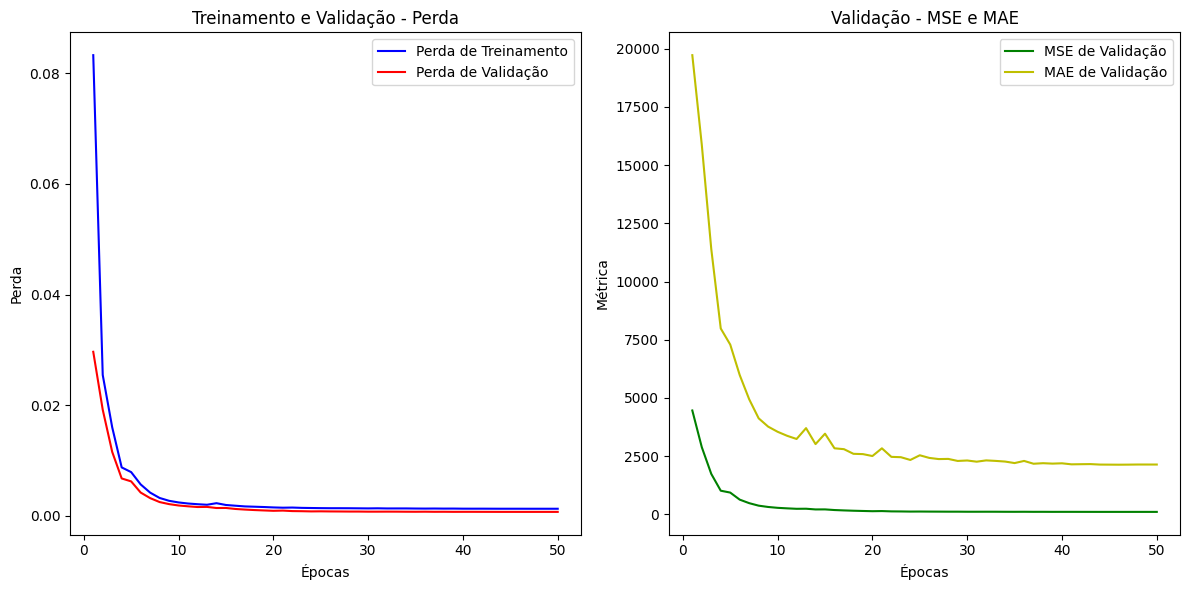

In [32]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)


# Ajustar o tamanho das listas para corresponder
min_length = min(len(epochs), len(val_mse), len(val_mae))
epochs = epochs[:min_length]
val_mse = val_mse[:min_length]
val_mae = val_mae[:min_length]

# Agora, plotar os gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Perda de Treinamento')
plt.plot(epochs, val_losses, 'r-', label='Perda de Validação')
plt.title('Treinamento e Validação - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_mse, 'g-', label='MSE de Validação')
plt.plot(epochs, val_mae, 'y-', label='MAE de Validação')
plt.title('Validação - MSE e MAE')
plt.xlabel('Épocas')
plt.ylabel('Métrica')
plt.legend()

plt.tight_layout()
plt.show()


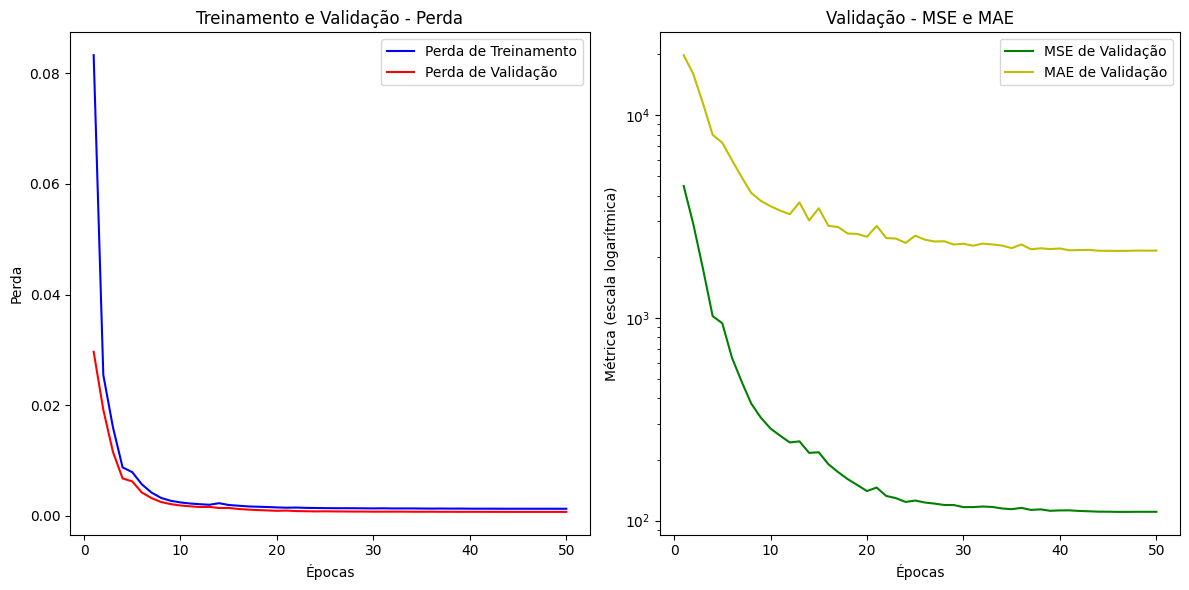

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

# Ajustar o tamanho das listas para corresponder
min_length = min(len(epochs), len(val_mse), len(val_mae))
epochs = epochs[:min_length]
val_mse = val_mse[:min_length]
val_mae = val_mae[:min_length]

# Agora, plotar os gráficos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Perda de Treinamento')
plt.plot(epochs, val_losses, 'r-', label='Perda de Validação')
plt.title('Treinamento e Validação - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_mse, 'g-', label='MSE de Validação')
plt.plot(epochs, val_mae, 'y-', label='MAE de Validação')
plt.title('Validação - MSE e MAE')
plt.xlabel('Épocas')
plt.ylabel('Métrica (escala logarítmica)')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()


swin_t


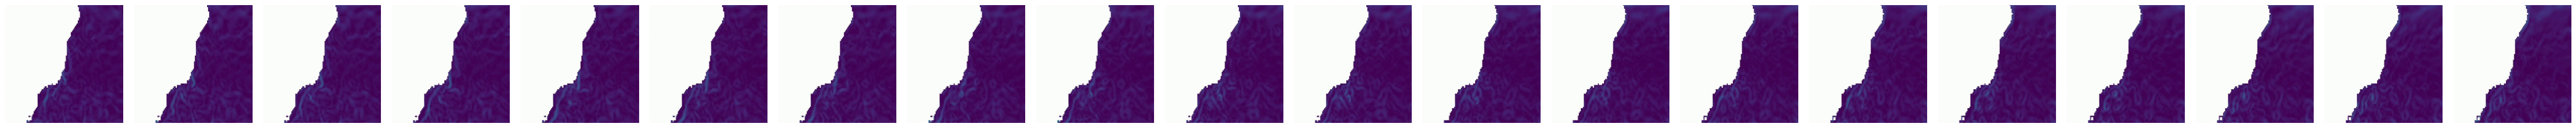

In [34]:
custom_exp = custom_training_config["ex_name"]
print(custom_exp)
inputs = np.load(f'./work_dirs/{custom_exp}/saved/inputs.npy')
preds = np.load(f'./work_dirs/{custom_exp}/saved/preds.npy')
trues = np.load(f'./work_dirs/{custom_exp}/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

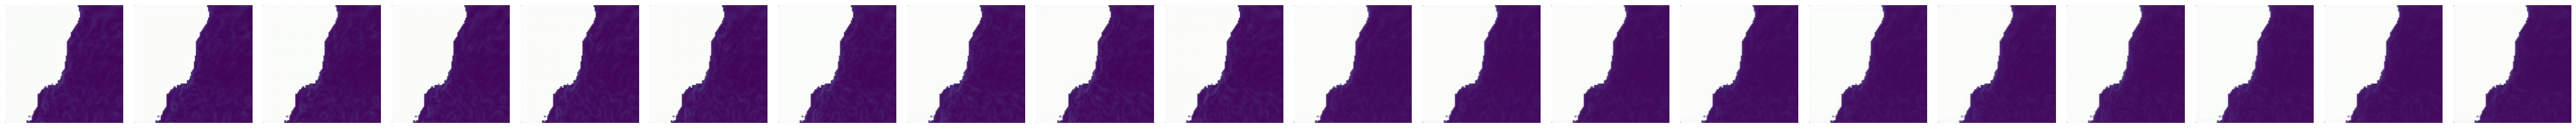

In [35]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

/content/OpenSTL/openstl/utils/visualization.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))


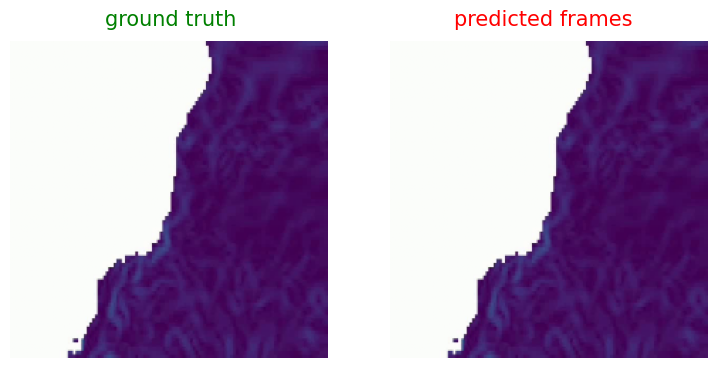

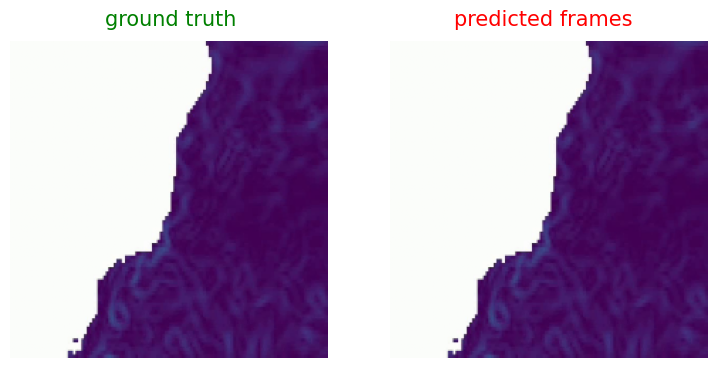

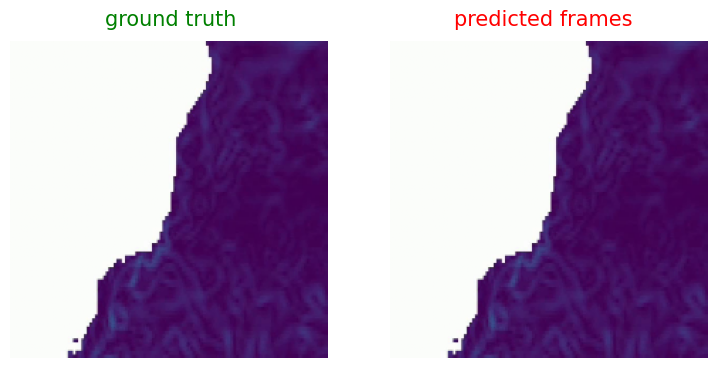

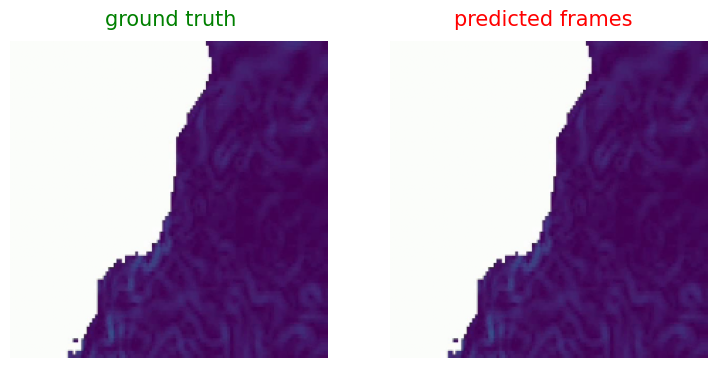

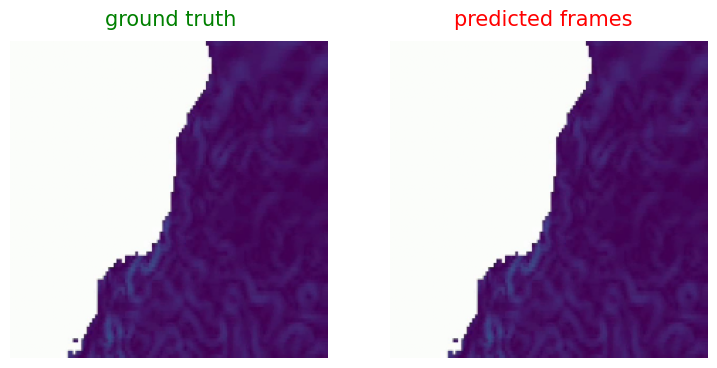

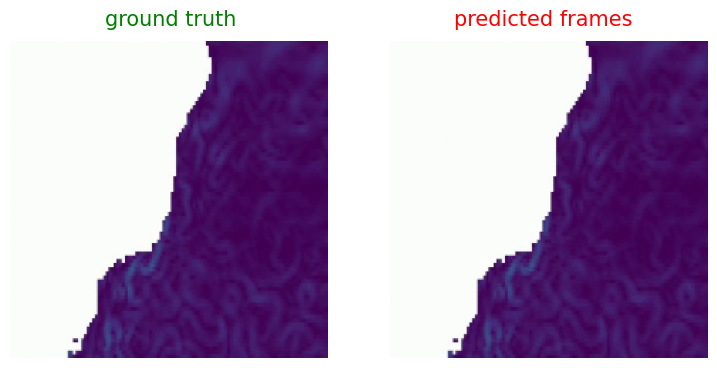

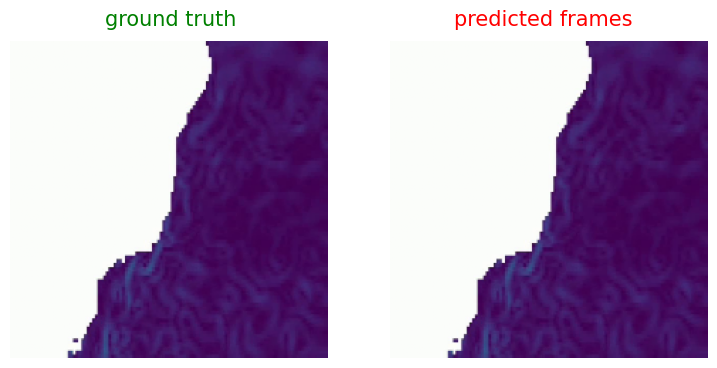

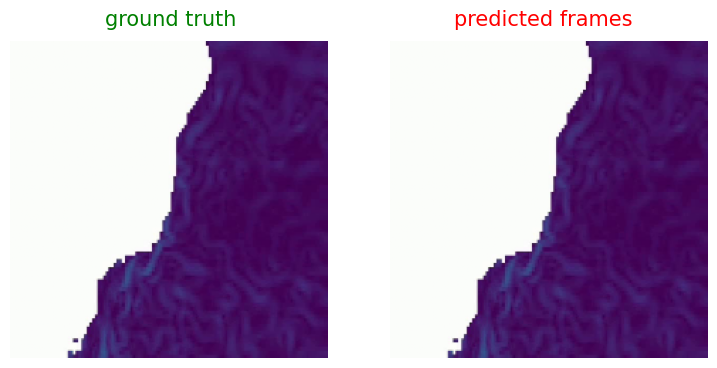

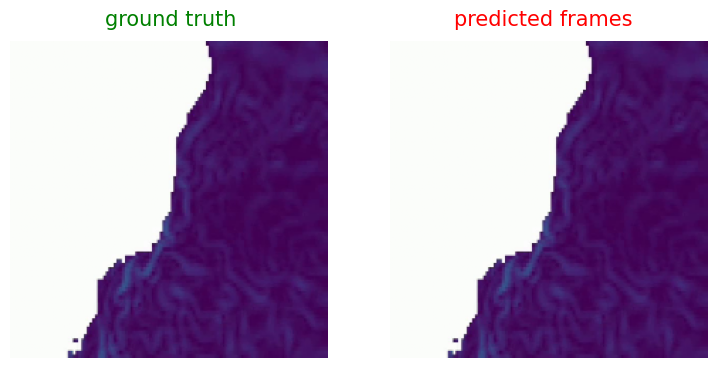

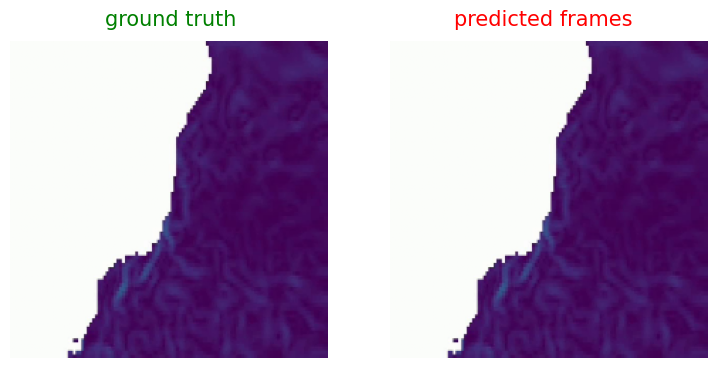

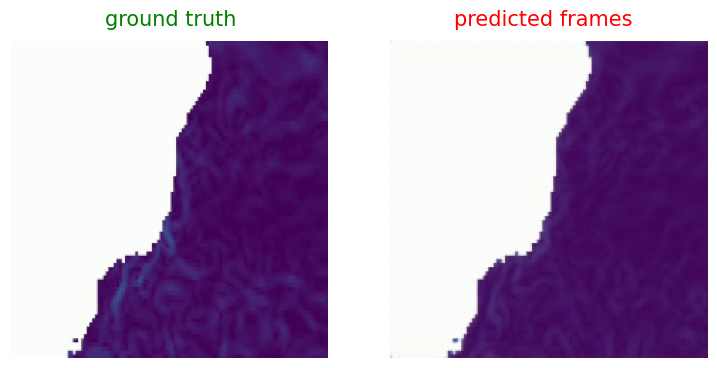

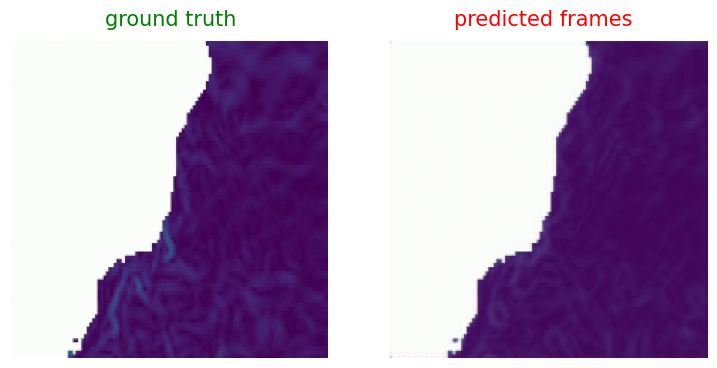

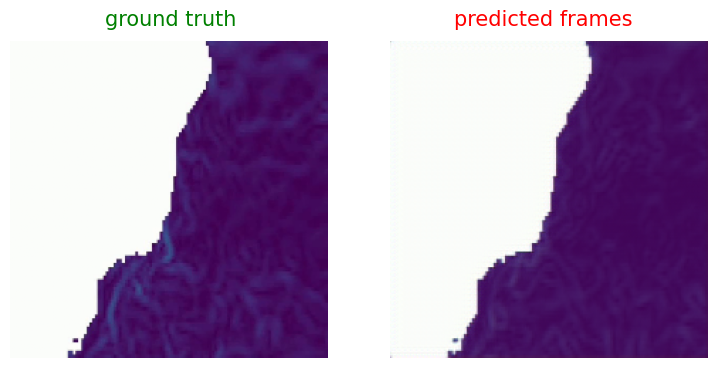

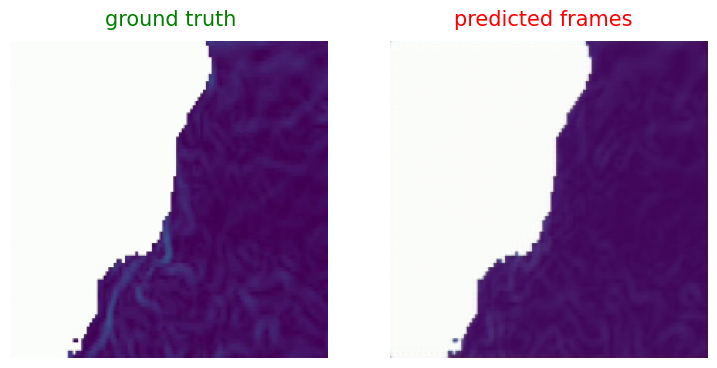

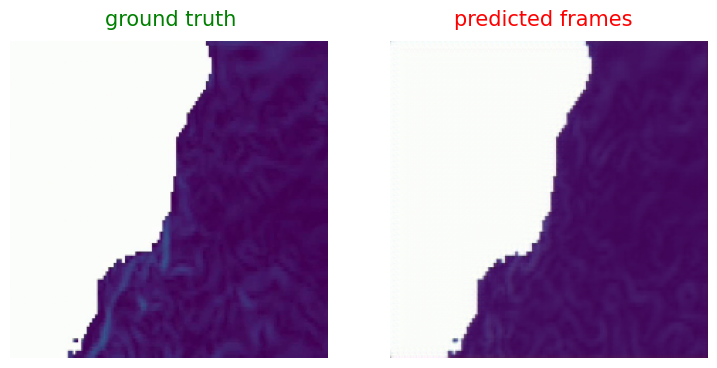

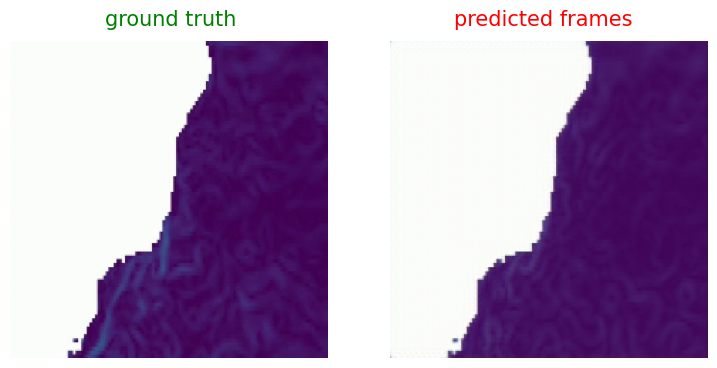

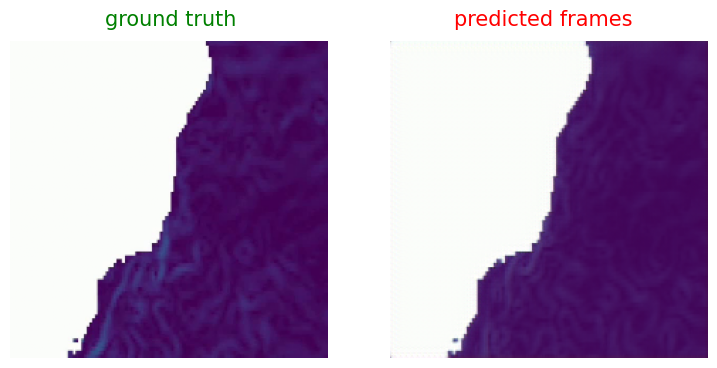

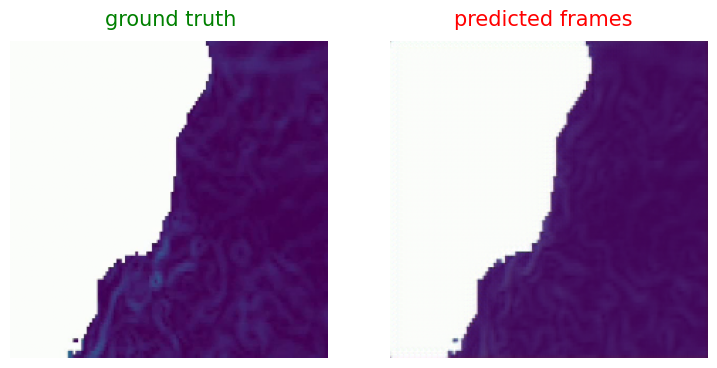

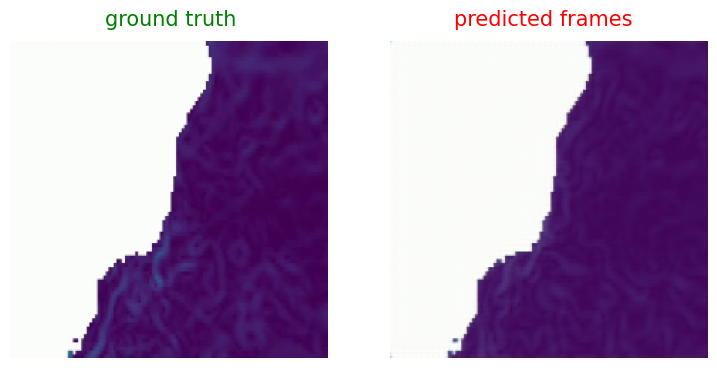

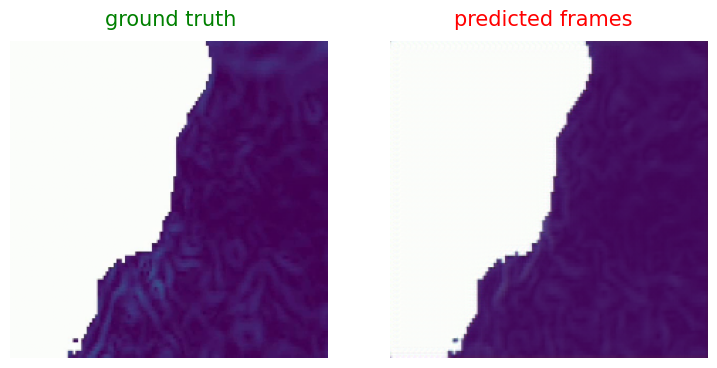

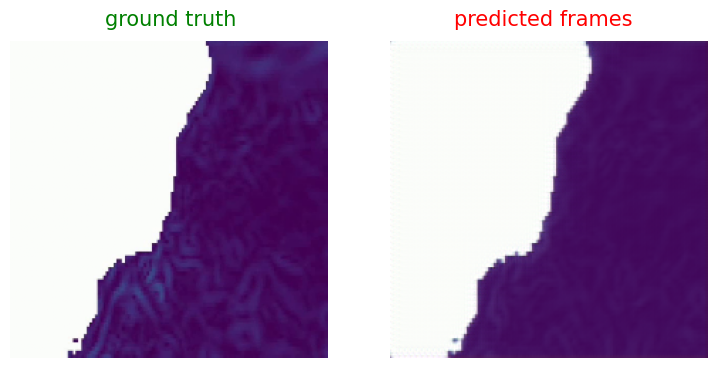

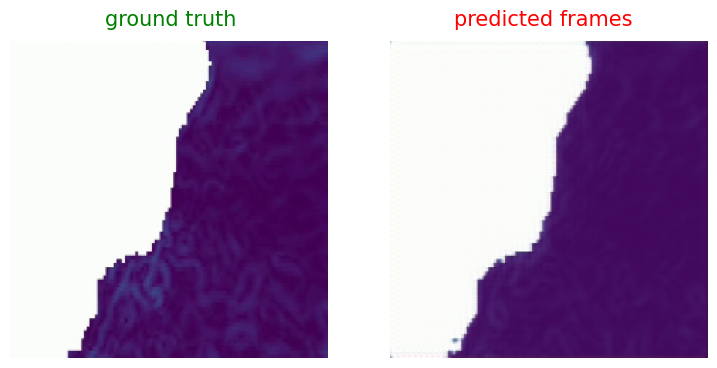

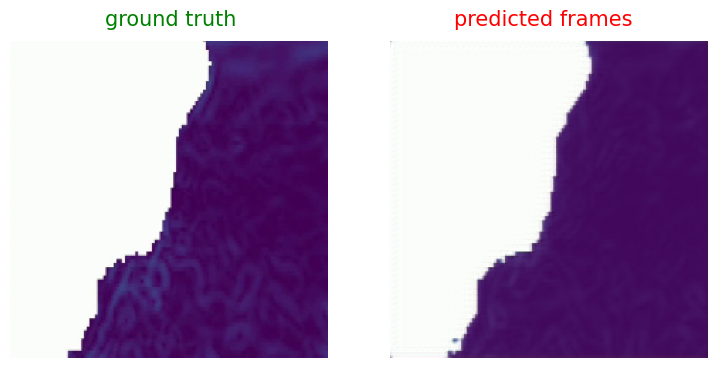

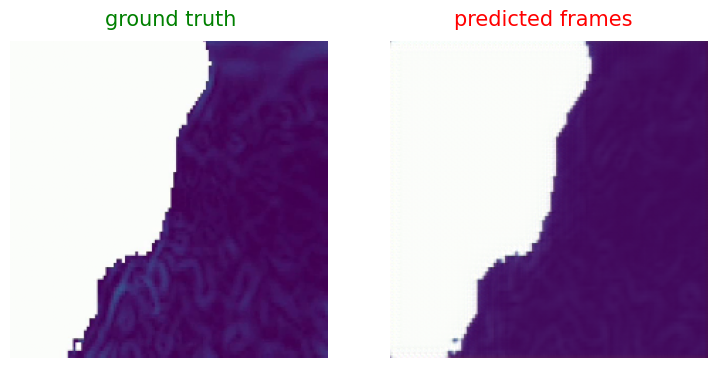

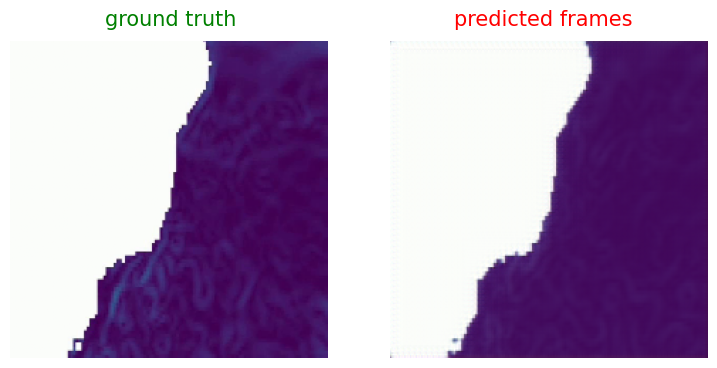

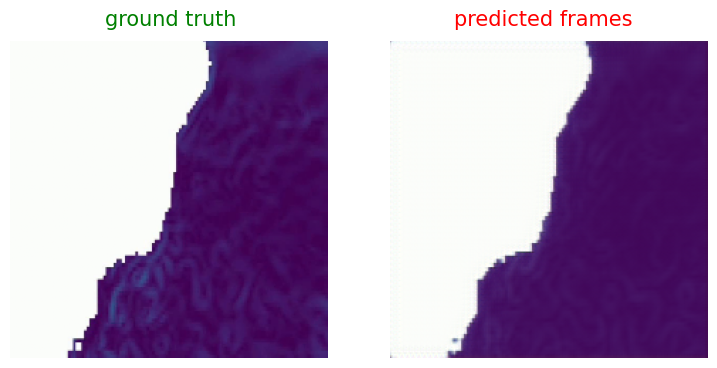

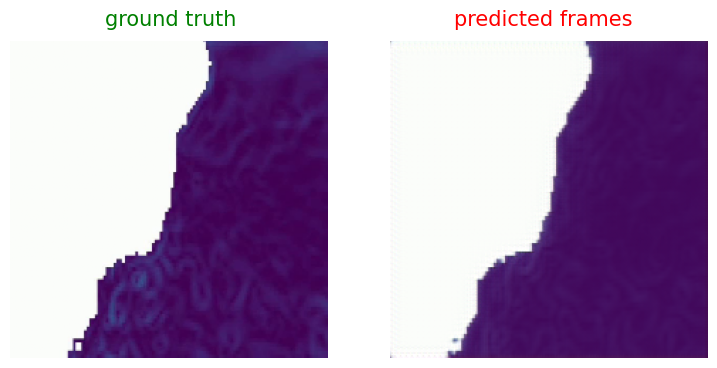

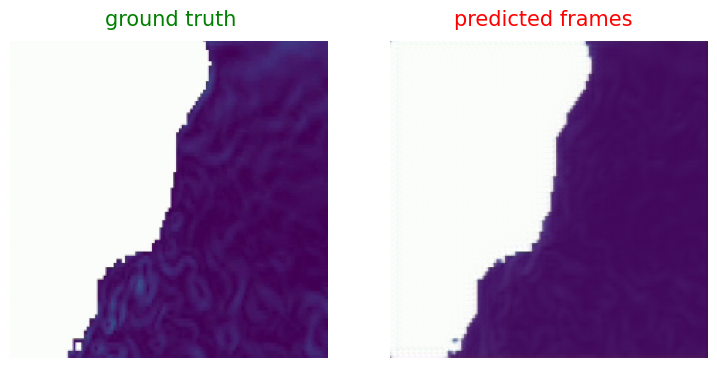

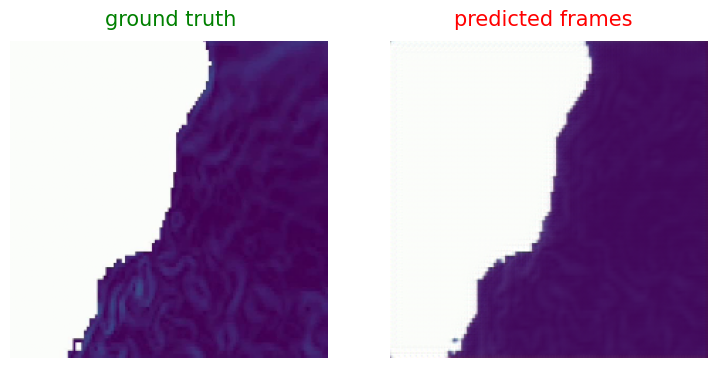

In [36]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path=f'{custom_exp}.gif')